# Part 1 - Data Collection and EDA

This notebook will focus on exploring data, analyzing an plotting insightful stats (class balance, image size distribution, etc.), loading data as 3-dimensional array, and preprocess data to prepare for modeling.

### Imports

In [43]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from PIL import Image
import h5py

### Load the data

In [44]:
# Define train and test directories
train_dir = './data/chest_xray/train/'
test_dir = './data/chest_xray/test/'

In [45]:
# Bacterial Pneumonia images
# glob class is to iterate all jpeg images in the directory and make a list of all image paths
b_images = glob(train_dir + '/bacterial/*.jpeg')

In [46]:
# Viral pneumonia images
v_images = glob(train_dir + '/viral/*.jpeg')

In [47]:
# Normal images
n_images = glob(train_dir + '/normal/*.jpeg')

### EDA

Let's create a bar plot for distribution of all three classes in train dataset.

Text(0.5, 1.0, 'Class Distribution')

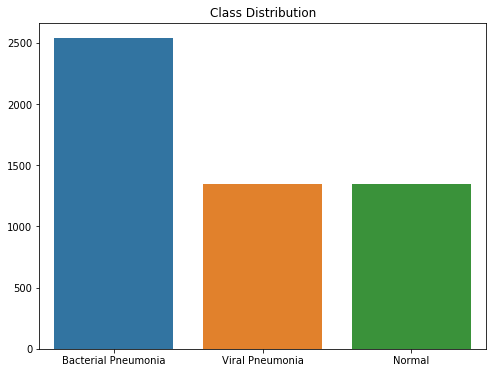

In [48]:
# Plot the class distribution
plt.figure(figsize=(8,6))
sns.barplot(['Bacterial Pneumonia', 'Viral Pneumonia', 'Normal'],[len(b_images),len(v_images), len(n_images)])
plt.title('Class Distribution')

This is obviously an unbalanced dataset, weighted to the chest X-rays with bacterial pneumonia. Considering bacterial pneumonia is the more severe than viral pneumonia, it is fine that our model learn about the specifics of bacterial pneumonia the most.

In [49]:
# Convert the first pneumonia image to array of pixels
np.asarray(plt.imread(b_images[0]))

array([[19, 19, 18, ...,  1,  0,  0],
       [19, 19, 18, ...,  1,  0,  0],
       [19, 19, 18, ...,  1,  0,  0],
       ...,
       [10, 10, 10, ..., 15, 15, 15],
       [10, 10, 10, ..., 15, 15, 15],
       [10, 10, 10, ..., 15, 15, 15]], dtype=uint8)

In [50]:
# Convert the first normal image to array of pixels
np.asarray(plt.imread(n_images[0]))

array([[ 22,  24,  24, ...,  96,  94,  93],
       [ 23,  24,  24, ...,  97,  94,  92],
       [ 24,  24,  23, ...,  99,  96,  94],
       ...,
       [ 49,  50,  48, ..., 119, 119, 119],
       [ 50,  52,  53, ..., 123, 124, 123],
       [ 52,  53,  54, ..., 129, 128, 127]], dtype=uint8)

In [51]:
# Check the shape of first pneumonia image array
np.asarray(plt.imread(b_images[0])).shape

(760, 1152)

In [52]:
# Check the shape of first normal image array
np.asarray(plt.imread(n_images[0])).shape

(1858, 2090)

It seems like image size is not uniform across the dataset and also too large to train a neural network in terms of time complexity. Let's also plot the image size distribution of train dataset to determine what would be the ideal height/width to downsize them

In [53]:
train_images = b_images + n_images + v_images

In [54]:
img_class = []
height = []
weight = []

# Iterate through each image path
for d in os.listdir(train_dir):
        # find height and width of all train images
        for image in train_images:
                img_class.append(d)
                img_array = np.array(Image.open(image))
                height.append(img_array.shape[0])
                weight.append(img_array.shape[1])


# save image sizes to data frame
size_df = pd.DataFrame({
    'class': img_class,
    'height': height,
    'width': weight
})

Text(0.5, 1.0, 'Image Size Distribution')

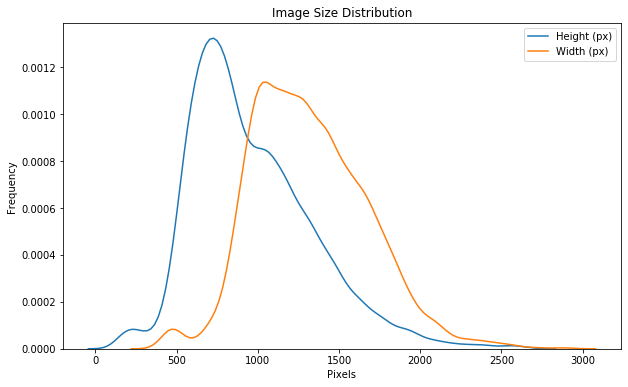

In [55]:
plt.figure(figsize = (10, 6))

sns.kdeplot(
    size_df['height'], label='Height (px)')
sns.kdeplot(
    size_df['width'], label='Width (px)')

plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')

Most images were at least 224 × 224 pixels and contained RGB color channels. Images that were smaller than
224 x 224 pixels or in greyscale should be removed from analysis. This was done after getting poor results with preprocessed images to smaller size and grayscale mode even though it gives faster results.

Let's plot some images to see the variations in terms of angle, zooming, opaqueness, etc. We know that the dataset was already cleaned up medical proffesionals for usability. However, plotting would guide us to determine the scale of data preprocessing and augmentation process.

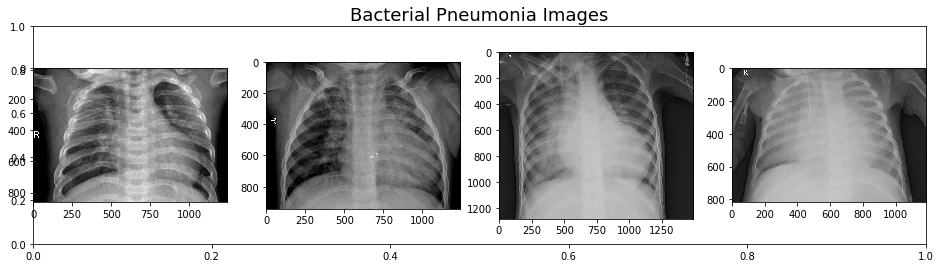

In [56]:
# Plot first four bacterial pneumonia images
fig=plt.figure(figsize=(16, 4))
plt.title('Bacterial Pneumonia Images', fontsize=18)
cols = 4
rows = 1
for i in range(1, cols*rows +1):
    img = np.asarray(plt.imread(b_images[i]))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

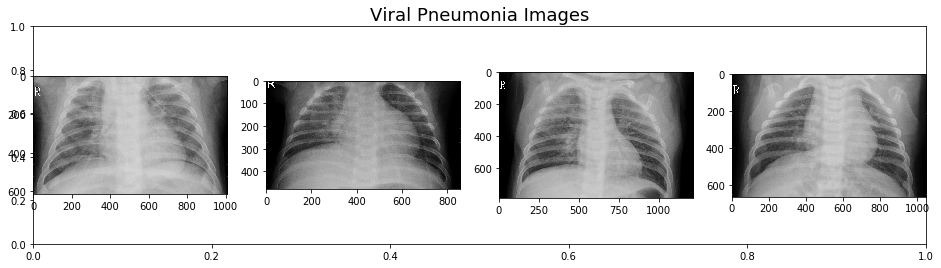

In [57]:
# Plot first four bacterial pneumonia images
fig=plt.figure(figsize=(16, 4))
plt.title('Viral Pneumonia Images', fontsize=18)
cols = 4
rows = 1
for i in range(1, cols*rows +1):
    img = np.asarray(plt.imread(v_images[i]))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

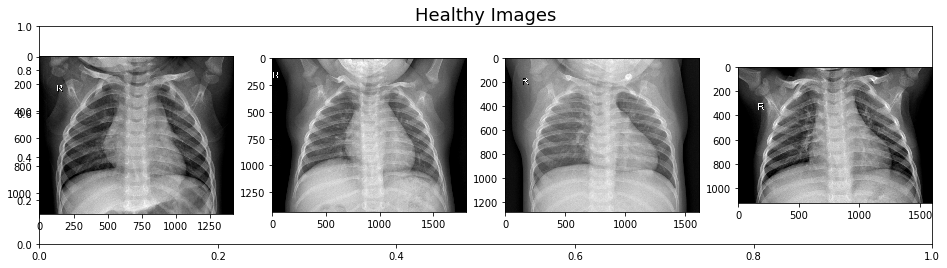

In [58]:
# Plot first four normal images
fig=plt.figure(figsize=(16, 4))
plt.title('Healthy Images', fontsize=18)
cols = 4
rows = 1
for i in range(1, cols*rows +1):
    img = np.asarray(plt.imread(n_images[i]))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

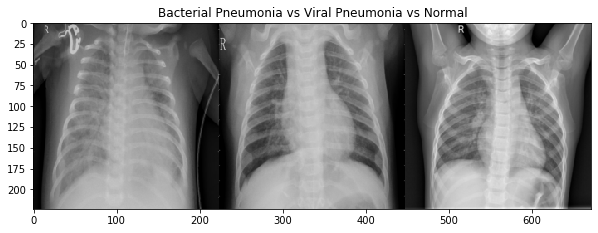

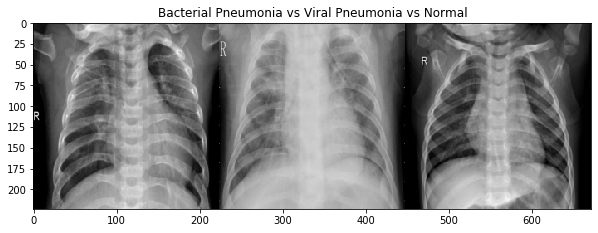

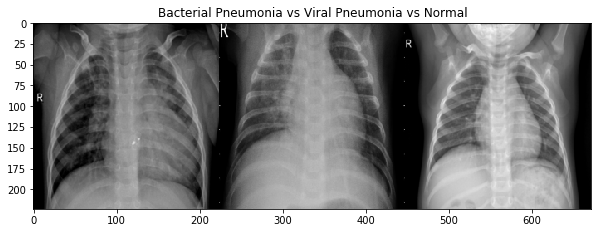

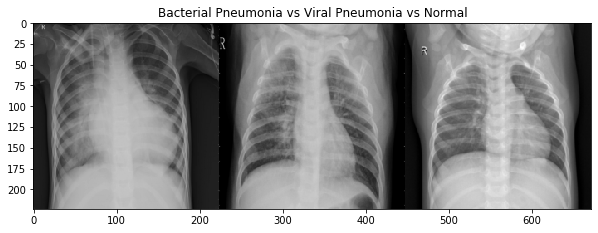

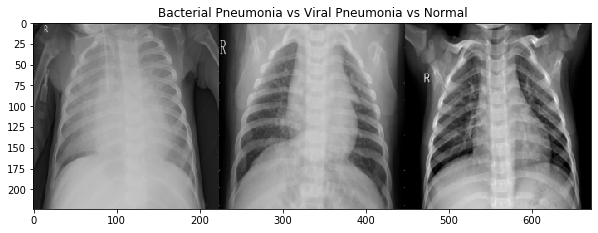

In [64]:
# Define a function to plot bacterial, viral, and normal images side by side

def pair_plot(index, img1_list, img2_list, img3_list):
    image1 = skimage.transform.resize(cv2.imread(img1_list[index]), (224, 224, 3))
    image2 = skimage.transform.resize(cv2.imread(img2_list[index]), (224, 224, 3))
    image3 = skimage.transform.resize(cv2.imread(img3_list[index]), (224, 224, 3))
    pair = np.concatenate((image1, image2, image3), axis=1)
    plt.figure(figsize=(10,8))
    plt.title("Bacterial Pneumonia vs Viral Pneumonia vs Normal")    
    plt.imshow(pair)
    plt.show()
    
for x in range(5):
    pair_plot(x, b_images, v_images, n_images)

Pneumonia positive images seems to be more faint as the borders between organs are less sharp because of the soft tissue (water) in the lungs.  
Black: Air  
Dark Grey: Fat  
Light Grey: Soft tissue  
Off white: Bone  
Bright white: Metal  

### Data Preprocessing

In [30]:
train_images = glob(train_dir+'/bacterial/*.jpeg')+glob(train_dir+'/viral/*.jpeg')+glob(train_dir+'/normal/*.jpeg')

In [31]:
test_images = glob(test_dir+'/bacterial/*.jpeg')+glob(test_dir+'/viral/*.jpeg')+glob(test_dir+'/normal/*.jpeg')

In [32]:
# Print folder names (classes)
print(os.listdir(train_dir))

['bacterial', 'normal', 'viral']


In [42]:
# Define a function to load the images to (256 X 256 X 3) numpy arrays (tensor)

def load_data(dir_path):
    X = []
    y = []
    
    for dir_name in os.listdir(dir_path):
        if dir_name == 'normal':
            label = 0
        elif dir_name == 'bacterial':
            label = 1
        elif dir_name == 'viral':
            label = 2
     
        image_paths = glob(dir_path + '/' + dir_name + '/*.jpeg')
        for image_file in image_paths:
            image = np.asarray(skimage.transform.resize(cv2.imread(image_file), (256, 256, 3)))
            X.append(image)
            y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [36]:
# Create train data (input) and target (output) arrays
X_train, y_train = load_data(train_dir)

In [37]:
# Create test data (input) and target (output) arrays
X_test, y_test = load_data(test_dir)

In [38]:
# Print size of train images and label arrays
print(f'Train size: {X_train.shape} \n {y_train.shape}')

Train size: (5232, 256, 256, 3) 
 (5232,)


In [39]:
# Print size of test images and label arrays
print(f'Test size: {X_test.shape} \n {y_test.shape}')

Test size: (624, 256, 256, 3) 
 (624,)


In [40]:
# Sanity check of first image array
X_train[0]

array([[[0.07058824, 0.07058824, 0.07058824],
        [0.0754902 , 0.0754902 , 0.0754902 ],
        [0.10098039, 0.10098039, 0.10098039],
        ...,
        [0.02254902, 0.02254902, 0.02254902],
        [0.00882353, 0.00882353, 0.00882353],
        [0.        , 0.        , 0.        ]],

       [[0.07058824, 0.07058824, 0.07058824],
        [0.08314951, 0.08314951, 0.08314951],
        [0.09705882, 0.09705882, 0.09705882],
        ...,
        [0.02647059, 0.02647059, 0.02647059],
        [0.01269914, 0.01269914, 0.01269914],
        [0.        , 0.        , 0.        ]],

       [[0.07352941, 0.07352941, 0.07352941],
        [0.0899663 , 0.0899663 , 0.0899663 ],
        [0.09411765, 0.09411765, 0.09411765],
        ...,
        [0.03039216, 0.03039216, 0.03039216],
        [0.01666667, 0.01666667, 0.01666667],
        [0.00294118, 0.00294118, 0.00294118]],

       ...,

       [[0.03921569, 0.03921569, 0.03921569],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0

In [41]:
y_train[0]

1

Below code was commented since I decided to proceed with ImageDataGenerator class to resize and modify images on the fly during trainnig my model. It is easier to make further adjustments by tuning parameters as opposed to recreating arrays and saving to file each time.

In [ ]:
# # Save train images as 3-dimensional array for further use in model
# with h5py.File('train_dataset.h5', 'w') as hf:
#     hf.create_dataset("train_images",  data=X_train)

In [ ]:
# # Save test images as 3-dimensional array for further use in model
# with h5py.File('test_dataset.h5', 'w') as hf:
#     hf.create_dataset("test_images",  data=X_test)